# Decision Tree

## Pull & Clean Datasets

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv('Data/hate_speech_training.csv')
df_train_2 = pd.read_csv('Data/hate_speech_training_2.csv')
df_train_3 = pd.read_csv('Data/hate_speech_training_3.csv')
df_train_4 = pd.read_csv('Data/hate_speech_training_4.tsv', sep = '\t')
df_train_5 = pd.read_csv('Data/hate_speech_training_5.csv')
df_test = pd.read_csv('Data/hate_speech_test.csv')

In [3]:
df_train = df_train.drop('id', axis = 1) #0 = Not Hate Speech, 1 = Hate Speech

In [4]:
df_train_2 = df_train_2[['tweet', 'class']]
df_train_2['class'] = df_train_2['class'].replace([0], 'hate speech')
df_train_2['class'] = df_train_2['class'].replace([1, 2], 'not hate speech')
df_train_2['class'] = df_train_2['class'].replace(['hate speech'], 1)
df_train_2['class'] = df_train_2['class'].replace(['not hate speech'], 0)
df_train_2.rename(columns = {'class': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [5]:
df_train_3 = df_train_3.drop('index', axis = 1) 
df_train_3.rename(columns = {'post': 'tweet'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [6]:
df_train_4 = df_train_4[['text', 'HS']] 
df_train_4.rename(columns = {'text': 'tweet', 'HS': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [7]:
df_train_5['Label'] = df_train_5['Label'].replace(['Hate', 'Non-Asian Aggression'], 1)
df_train_5['Label'] = df_train_5['Label'].replace(['Neutral', 'Counterhate'], 0) 
df_train_5.rename(columns = {'Text': 'tweet', 'Label': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [8]:
dfs = [df_train, df_train_2, df_train_3, df_train_4, df_train_5]
df = pd.concat(dfs)

## Train, Test, Split

In [9]:
from sklearn.model_selection import train_test_split

In [37]:
X = df['tweet']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=3,
                                                    test_size=0.20,
                                                   stratify = y) #80/20 split

## Natural Language Processing (NLP)

The goal here will actually to be to not only use grid searches but to also test both TF-IDF (Term Frequency - Inverse Document Frequency) and Count Vectorizers to see which performs better with each model

### TF-IDF

In [11]:
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [12]:
sw = stopwords.words('english')

In [13]:
def get_wordnet_pos(treebank_tag):
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [14]:
def doc_preparer(doc, stop_words=sw):
 
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [15]:
token_docs = [doc_preparer(doc, sw) for doc in X_train]

In [16]:
tfidf = TfidfVectorizer()
X_t, X_val, y_t, y_val = train_test_split(token_docs, y_train,
                                          test_size=0.20, random_state=3)

In [17]:
X_t_vec = tfidf.fit_transform(X_t)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(tfidf.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

In [18]:
X_val_vec = tfidf.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tfidf.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

### Count Vectorizer

In [19]:
cv = CountVectorizer()
X_c_vec = cv.fit_transform(X_t)
X_c_vec = pd.DataFrame.sparse.from_spmatrix(X_c_vec)
X_c_vec.columns = sorted(cv.vocabulary_)
X_c_vec.set_index(y_t.index, inplace=True)

In [20]:
X_c_val_vec = cv.transform(X_val)
X_c_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_c_val_vec)
X_c_val_vec.columns = sorted(cv.vocabulary_)
X_c_val_vec.set_index(y_val.index, inplace=True)

## Modeling TF-IDF on Decision Tree

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [22]:
dtf_tfidf = DecisionTreeClassifier()
dtf_tfidf.fit(X_t_vec, y_t)

DecisionTreeClassifier()

In [23]:
dtf_tfidf.score(X_t_vec, y_t)

0.9997738375248779

In [25]:
cross_val_score(dtf_tfidf, X_t_vec, y_t, cv = 5)

array([0.91598824, 0.9183535 , 0.91914509, 0.917675  , 0.91891892])

In [26]:
dtf_tfidf.score(X_val_vec, y_val)

0.9154228855721394

In [27]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report

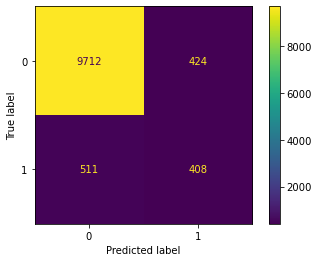

In [28]:
plot_confusion_matrix(dtf_tfidf, X_val_vec, y_val)

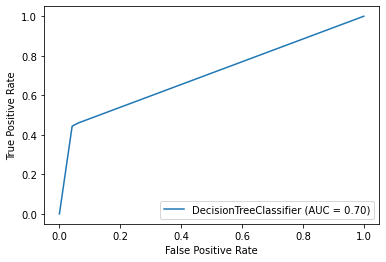

In [29]:
plot_roc_curve(dtf_tfidf, X_val_vec, y_val)

In [30]:
y_hat = dtf_tfidf.predict(X_val_vec)
print(classification_report(y_pred = y_hat, y_true = y_val))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     10136
           1       0.49      0.44      0.47       919

    accuracy                           0.92     11055
   macro avg       0.72      0.70      0.71     11055
weighted avg       0.91      0.92      0.91     11055



## Grid Search for TF-IDF on Decision Tree

In [31]:
from sklearn.model_selection import GridSearchCV
grid_params = {'criterion': ['gini', 'entropy'],
              'max_depth': range(1, 10),
              'min_samples_split': range(1, 10),
              'min_samples_leaf': range(1, 5)}

In [32]:
gs_tfidf = GridSearchCV(DecisionTreeClassifier(),
                 grid_params,
                 verbose = 1,
                 cv = 3,
                 n_jobs = 3)

In [33]:
gs_tfidf.fit(X_t_vec, y_t)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 43.4min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed: 165.2min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed: 340.0min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 587.1min
[Parallel(n_jobs=3)]: Done 1244 tasks      | elapsed: 900.9min
[Parallel(n_jobs=3)]: Done 1794 tasks      | elapsed: 1339.7min
[Parallel(n_jobs=3)]: Done 1944 out of 1944 | elapsed: 1450.1min finished


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=3,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(1, 10)},
             verbose=1)

In [34]:
gs_tfidf.best_score_

0.920797907780787

In [35]:
gs_tfidf.best_estimator_

DecisionTreeClassifier(max_depth=9, min_samples_split=8)

In [36]:
gs_tfidf.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 8}

## Best Possible Model for Decision Tree with TF-IDF